In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

In [2]:
with open("/workspace/deception-detection/results/by_layer_repe_clean_10000_control_lr__repe_honesty__plain__llama-70b-3.3__20251214_152721/scores_by_layer.json", "r") as f:
    scores = json.load(f)

In [3]:
scores.keys()

dict_keys(['repe_honesty__plain_val', 'roleplaying_poisoned__plain', 'alpaca__plain'])

In [4]:
all_layers_control_scores = []
all_layers_roleplaying_scores = []
for layer in tqdm(range(80)):
    control_scores = scores["alpaca__plain"][str(layer)]
    roleplaying_scores = scores["roleplaying_poisoned__plain"][str(layer)]
    
    promptwise_control_scores = [np.mean(control_score) for control_score in control_scores["scores"]]
    roleplaying_scores_all = roleplaying_scores["scores"]
    roleplaying_labels_all = roleplaying_scores["labels"]
    promptwise_roleplaying_scores = []
    for i, label in enumerate(roleplaying_labels_all):
        if label == 'DECEPTIVE':
            promptwise_roleplaying_scores.append(np.mean(roleplaying_scores_all[i]))
            
    all_layers_control_scores.append(promptwise_control_scores)
    all_layers_roleplaying_scores.append(promptwise_roleplaying_scores)

100%|██████████| 80/80 [00:03<00:00, 20.10it/s]


In [5]:
len(all_layers_control_scores), len(all_layers_roleplaying_scores)

(80, 80)

In [6]:
def auroc(scores, labels):
    return roc_auc_score(labels, scores)

def tpr_at_1pct_fpr(scores, labels):
    # threshold from class_0 only
    thresh = np.percentile(scores[labels == 0], 99)
    preds = scores >= thresh
    tpr = (preds & (labels == 1)).sum() / (labels == 1).sum()
    return tpr


In [ ]:
def get_results(
    ls_1, 
    ls_2, 
    ls_3, 
    ls_4,
    i, 
    j, 
    output_dir
):
    
    ls_1 = np.array(ls_1)
    ls_2 = np.array(ls_2)
    ls_3 = np.array(ls_3)
    ls_4 = np.array(ls_4)
    
    y_A = np.concatenate([np.zeros(len(ls_1)), np.ones(len(ls_2))])
    y_B = np.concatenate([np.zeros(len(ls_3)), np.ones(len(ls_4))])
    
    scores_A = np.concatenate([ls_1, ls_2])
    scores_B = np.concatenate([ls_3, ls_4])
    
    def ensemble_scores(w):
        scores_0 = w * ls_1 + (1 - w) * ls_3
        scores_1 = w * ls_2 + (1 - w) * ls_4
        scores = np.concatenate([scores_0, scores_1])
        labels = np.concatenate([np.zeros(len(scores_0)), np.ones(len(scores_1))])
        return scores, labels
    
    ## Optimize AUROC
    ws = np.linspace(0, 1, 201)
    aurocs = []

    for w in ws:
        scores, labels = ensemble_scores(w)
        aurocs.append(auroc(scores, labels))

    best_w_auroc = ws[np.argmax(aurocs)]
    best_auroc = max(aurocs)
    
    ## Optimize tpr
    tprs = []

    for w in ws:
        scores, labels = ensemble_scores(w)
        tprs.append(tpr_at_1pct_fpr(scores, labels))

    best_w_tpr = ws[np.argmax(tprs)]
    best_tpr = max(tprs)
    
    if i >= j:
        plt.figure(figsize=(7, 4))
        plt.plot(ws, aurocs, label="AUROC")
        plt.plot(ws, tprs, label="TPR @ 1% FPR")
        plt.axvline(best_w_auroc, linestyle="--", alpha=0.5)
        plt.axvline(best_w_tpr, linestyle="--", alpha=0.5, color="orange")
        plt.xlabel("Ensemble weight w (Classifier A)")
        plt.ylabel("Metric value")
        plt.legend()
        plt.title("Ensemble performance vs weighting")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"ensemble_performance_layer_{i}_and_{j}.png"))
        plt.close()
    
    return best_auroc, best_tpr
    

In [9]:
output_dir = "/workspace/deception-detection/results/soft_ensembling_results_roleplaying"
best_auroc_ls = [[] for _ in range(12)]
best_tpr_ls = [[] for _ in range(12)]
for i in (range(20, 32)):
    for j in tqdm(range(20, 32)):  
        best_auroc, best_tpr = get_results(
            all_layers_control_scores[i],
            all_layers_roleplaying_scores[i],
            all_layers_control_scores[j],
            all_layers_roleplaying_scores[j],
            i,
            j,
            output_dir
        )
        
        best_auroc_ls[i - 20].append(best_auroc)
        best_tpr_ls[i - 20].append(best_tpr)
        

100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


In [12]:
best_auroc_all_single_probe_ls = []
best_tpr_all_single_probe_ls = []
for i in range(80):
    layer_control_scores = all_layers_control_scores[i]
    layer_roleplaying_scores = all_layers_roleplaying_scores[i]
    y = np.concatenate([np.zeros(len(layer_control_scores)), np.ones(len(layer_roleplaying_scores))])
    scores = np.concatenate([layer_control_scores, layer_roleplaying_scores])
    best_auroc_all_single_probe_ls.append(auroc(scores, y))
    best_tpr_all_single_probe_ls.append(tpr_at_1pct_fpr(scores, y))

In [15]:
layer_21_auroc = best_auroc_all_single_probe_ls[21]
layer_21_tpr = best_tpr_all_single_probe_ls[21]
print(f"Layer 21 single probe AUROC: {layer_21_auroc:.4f}, TPR@1%FPR: {layer_21_tpr:.4f}")

Layer 21 single probe AUROC: 0.9946, TPR@1%FPR: 0.9064


In [19]:
diff_best_auroc_ls = [[] for _ in range(12)]
diff_best_tpr_ls = [[] for _ in range(12)]
for i in range(12):
    for j in range(12):
        diff_best_auroc = best_auroc_ls[i][j] - layer_21_auroc
        diff_best_tpr = best_tpr_ls[i][j] - layer_21_tpr
        diff_best_auroc_ls[i].append(diff_best_auroc)
        diff_best_tpr_ls[i].append(diff_best_tpr)
            

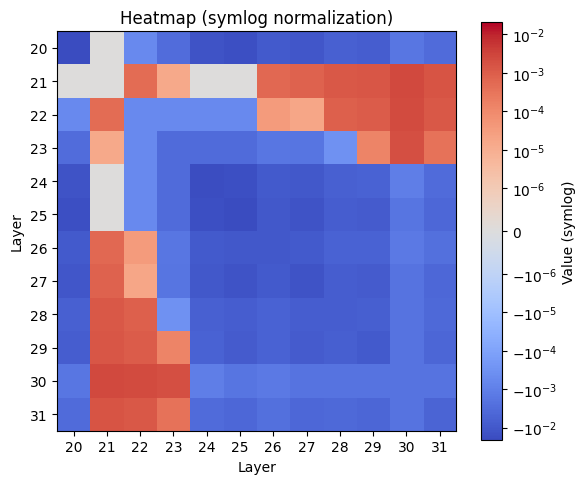

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

data = np.array(diff_best_auroc_ls)
v = np.max(np.abs(data))

layers = list(range(20, 32))  # 20, 21, ..., 31

plt.figure(figsize=(6, 5))
im = plt.imshow(
    data,
    cmap="coolwarm",
    norm=SymLogNorm(
        linthresh=1e-6,
        vmin=-v,
        vmax=v
    )
)

plt.colorbar(im, label="Value (symlog)")

# --- Axis ticks and labels ---
plt.xticks(ticks=np.arange(len(layers)), labels=layers)
plt.yticks(ticks=np.arange(len(layers)), labels=layers)

plt.xlabel("Layer")
plt.ylabel("Layer")

plt.title("Heatmap (symlog normalization)")
plt.tight_layout()
plt.show()


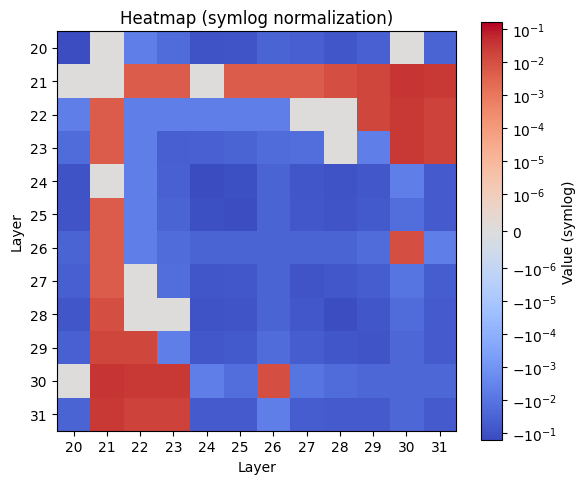

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

data = np.array(diff_best_tpr_ls)
v = np.max(np.abs(data))

layers = list(range(20, 32))  # 20, 21, ..., 31

plt.figure(figsize=(6, 5))
im = plt.imshow(
    data,
    cmap="coolwarm",
    norm=SymLogNorm(
        linthresh=1e-6,
        vmin=-v,
        vmax=v
    )
)

plt.colorbar(im, label="Value (symlog)")

# --- Axis ticks and labels ---
plt.xticks(ticks=np.arange(len(layers)), labels=layers)
plt.yticks(ticks=np.arange(len(layers)), labels=layers)

plt.xlabel("Layer")
plt.ylabel("Layer")

plt.title("Heatmap (symlog normalization)")
plt.tight_layout()
plt.show()
